In [272]:
from dataclasses import dataclass, field
from typing import Sequence, Optional, Dict

import clingo.ast
import descartes
import matplotlib.pyplot as plt
from clingo import PropagateInit, PropagateControl
from clingo.ast import ProgramBuilder
from shapely.geometry import Polygon

In [273]:
db = {
    "square1": Polygon([(0, 0), (2, 0), (2, 2), (0, 2)]),
    "square2": Polygon([(1, 1), (3, 1), (3, 3), (1, 3)]),
}
db

{'square1': <shapely.geometry.polygon.Polygon at 0x7f1776f86050>,
 'square2': <shapely.geometry.polygon.Polygon at 0x7f1776f85210>}

In [274]:
data = """
type(polygon).

product(polygon, "square1").
product(polygon, "square2").
"""

In [275]:
program = """
do_intersect("square1", "intersect_1_2").
do_intersect("square2", "intersect_1_2").

&intersect{ P: product(polygon, P), do_intersect(P, Intersect_P) } = intersect(polygon, Intersect_P) :-
  do_intersect(_, Intersect_P).

product(polygon, Intersect_P) :-
  do_intersect(_, Intersect_P),
  &intersect { P: product(polygon, P), do_intersect(P, Intersect_P) } = intersect(polygon, Intersect_P).

"""

In [276]:
theory = """
#theory spatial {
	constant  {};
	spatial_term {};
	&union/1 : spatial_term, {=}, constant, any;
	&intersect/1 : spatial_term, {=}, constant, any
}.
"""

In [277]:
def rewrap(theory_term: clingo.TheoryTerm):
    if theory_term.type is clingo.TheoryTermType.Symbol:
        return clingo.Function(theory_term.name)
    elif theory_term.type is clingo.TheoryTermType.Number:
        return clingo.Number(theory_term.number)
    elif theory_term.type is clingo.TheoryTermType.Function:
        name: str = theory_term.name
        arguments = (rewrap(argument) for argument in theory_term.arguments)
        return clingo.Function(name, tuple(arguments))
    arguments = (rewrap(argument) for argument in theory_term.arguments)
    if theory_term.type is clingo.TheoryTermType.Set:
        return clingo.String(str(set(arguments)))
    elif theory_term.type is clingo.TheoryTermType.Tuple:
        return clingo.Tuple_(tuple(arguments))
    elif theory_term.type is clingo.TheoryTermType.List:
        return clingo.String(str(list(arguments)))
    else:
        assert False, "Unknown TheoryTermType {} of TheoryTerm {}.".format(theory_term.type, theory_term)


def unwrap(theory_term: clingo.TheoryTerm):
    if theory_term.type is clingo.TheoryTermType.Symbol:
        if theory_term.name.startswith('"') and theory_term.name.endswith('"'):
            return theory_term.name[1:-1]
        return theory_term.name
    elif theory_term.type is clingo.TheoryTermType.Number:
        return theory_term.number
    elif theory_term.type is clingo.TheoryTermType.Function:
        name: str = theory_term.name
        arguments = (rewrap(argument) for argument in theory_term.arguments)
        return clingo.Function(name, tuple(arguments))
    arguments = (unwrap(argument) for argument in theory_term.arguments)
    if theory_term.type is clingo.TheoryTermType.Set:
        return set(arguments)
    elif theory_term.type is clingo.TheoryTermType.Tuple:
        return tuple(arguments)
    elif theory_term.type is clingo.TheoryTermType.List:
        return list(arguments)
    else:
        assert False, "Unknown TheoryTermType {} of TheoryTerm {}.".format(theory_term.type, theory_term)

In [278]:
class SpatialTransformer(clingo.ast.Transformer):

    def visit_Rule(self, rule: clingo.ast.AST, loc :Optional[str] = None):
        new_head = rule.head
        if rule.head.ast_type is clingo.ast.ASTType.TheoryAtom:
            new_head = self.visit(rule.head, 'head')
        new_body = []
        for literal in rule.body:
            new_literal = literal
            if literal.atom.ast_type == clingo.ast.ASTType.TheoryAtom:
                new_literal = self.visit(literal, 'body')
            new_body.append(new_literal)
        return clingo.ast.Rule(rule.location, new_head, new_body)

    def visit_TheoryAtom(self, theory_atom: clingo.ast.AST, loc: Optional[str] = None):
        if loc is not None:
            theory_atom.term.arguments.insert(0, clingo.ast.Function(theory_atom.location, loc, [], False))
        return theory_atom


In [279]:
class SpatialPropagator(clingo.Propagator):

    def __init__(self, database: Optional[Dict[str, Polygon]] = None):
        self._l2t = {}     # literal -> (op, geoms, assign)
        self._lih = set()  # literals in head
        self._lib = set()  # literals in body
        self._a2l = {}     # assign -> literal
        self._l2s = {}     # literal -> solver_literal
        self._s2l = {}     # solver_literal -> literal
        self._qrst = QRST(database)

    def init(self, init: PropagateInit) -> None:
        for atom in init.theory_atoms:
            term = atom.term
            op = term.name
            geoms = sorted(unwrap(element.terms[0]) for element in atom.elements)
            assign = unwrap(atom.guard[1])
            program_literal = atom.literal
            solver_literal = init.solver_literal(program_literal)
            if program_literal not in self._l2t:
                self._l2t[program_literal] = (op, geoms, assign)
            if program_literal not in self._l2s:
                self._l2s[program_literal] = solver_literal
            if solver_literal not in self._s2l:
                self._s2l[solver_literal] = program_literal
                init.add_watch(solver_literal)
            loc = term.arguments[0].name

            if loc == 'head':
                self._lih.add(program_literal)
                if assign not in self._a2l:
                    self._a2l[assign] = program_literal
                if init.assignment.is_true(solver_literal):
                    self.propagate_assignment(op, geoms, assign)
            elif loc == 'body':
                self._lib.add(program_literal)

        for head_literal in self._lih:
            for body_literal in self._lib:
                if self._l2t[head_literal] == self._l2t[body_literal]:
                    head_solver_literal = self._l2s[head_literal]
                    body_solver_literal = self._l2s[body_literal]
                    init.add_clause((head_solver_literal, -body_solver_literal))
                    init.add_clause((-head_solver_literal, body_solver_literal))

    def propagate(self, control: PropagateControl, changes: Sequence[int]) -> None:
        for change in changes:
            if change in self._s2l:
                program_literal = self._s2l[change]
                op, geoms, assign = self._l2t[program_literal]
                self.propagate_assignment(op, geoms, assign)

    def propagate_assignment(self, op, geoms, assign):
        self._qrst.evaluate(op, geoms, assign)

    def on_model(self, model: clingo.Model) -> Optional[bool]:
        geometry_symbols = tuple(
            clingo.Function('geometry', (clingo.String(geom_id), clingo.String(str(list(polygon.exterior.coords)))))
            for geom_id, polygon in self._qrst.db.items())
        assign_symbols = tuple(clingo.Function('assigned', (assign, clingo.String(geom_id))) for
                               assign, geom_id in self._qrst.assignments.items())
        model.extend(geometry_symbols)
        model.extend(assign_symbols)
        return





In [280]:

@dataclass
class QRST:
    db: Dict[str, Polygon] = field(default_factory=dict)                 # geom_id -> polygon
    assignments: Dict[clingo.Symbol, str] = field(default_factory=dict)  # assign -> geom_id

    def evaluate(self, operation: str, geoms: str, assign: clingo.Symbol) -> None:
        geom_id: str = "{}({})".format(operation, ','.join(sorted(geoms)))
        if geom_id not in self.db:
            if operation == 'intersect':
                self.intersect(geom_id, geoms)
            elif operation == 'union':
                self.union(geom_id, geoms)

        assert assign not in self.assignments or self.assignments[assign] == geom_id, "Should not overwrite assignment."
        self.assignments[assign] = geom_id

    def intersect(self, geom_id: str, geoms: Sequence[str]) -> None:
        polys = list(self.db[geom] for geom in geoms)
        new_poly = polys[0]
        i = 1
        while i < len(polys):
            new_poly = new_poly.intersection(polys[i])
            i += 1
        self.db[geom_id] = new_poly

    def union(self, geom_id: str, geoms: Sequence[str]) -> None:
        polys = list(self.db[geom] for geom in geoms)
        new_poly = polys[0]
        i = 1
        while i < len(polys):
            new_poly = new_poly.union(polys[i])
            i += 1
        self.db[geom_id] = new_poly



In [281]:
ctl = clingo.Control()
ctl.configuration.solve.models = 0

In [282]:
propagator = SpatialPropagator(db)
transformer = SpatialTransformer()

In [283]:
ctl.register_propagator(propagator)

In [284]:
ctl.add('base', [], theory)
print(theory)
ctl.add('base', [], data)
print(data)
stmts = []
clingo.ast.parse_string(program, lambda stm: stmts.append(transformer.visit(stm)))
with ProgramBuilder(ctl) as builder:
    for stm in stmts:
        print(stm)
        builder.add(stm)


#theory spatial {
	constant  {};
	spatial_term {};
	&union/1 : spatial_term, {=}, constant, any;
	&intersect/1 : spatial_term, {=}, constant, any
}.


type(polygon).

product(polygon, "square1").
product(polygon, "square2").

#program base.
do_intersect("square1","intersect_1_2").
do_intersect("square2","intersect_1_2").
&intersect(head) { P: product(polygon,P), do_intersect(P,Intersect_P) } = intersect(polygon,Intersect_P) :- do_intersect(_,Intersect_P).
product(polygon,Intersect_P) :- do_intersect(_,Intersect_P); &intersect(body) { P: product(polygon,P), do_intersect(P,Intersect_P) } = intersect(polygon,Intersect_P).


In [285]:
ctl.ground([('base', ())])

In [286]:
with ctl.solve(yield_=True, on_model=propagator.on_model) as solve_handle:
    models = []
    for model in solve_handle:
        symbols = sorted(model.symbols(shown=True, theory=True))
        models.append(model)
        print("Answer {}:".format(model.number), end=' ')
        print("{",
              '\n'.join(map(str, symbols)), "}", sep='\n')
    solve_result = solve_handle.get()
    print(solve_result, end='')
    if models:
        print(" {}{}".format(len(models), '' if solve_result.exhausted else '+'))

Answer 1: {
type(polygon)
assigned(intersect(polygon,"intersect_1_2"),"intersect(square1,square2)")
do_intersect("square1","intersect_1_2")
do_intersect("square2","intersect_1_2")
geometry("intersect(square1,square2)","[(2.0, 2.0), (2.0, 1.0), (1.0, 1.0), (1.0, 2.0), (2.0, 2.0)]")
geometry("square1","[(0.0, 0.0), (2.0, 0.0), (2.0, 2.0), (0.0, 2.0), (0.0, 0.0)]")
geometry("square2","[(1.0, 1.0), (3.0, 1.0), (3.0, 3.0), (1.0, 3.0), (1.0, 1.0)]")
product(polygon,"intersect_1_2")
product(polygon,"square1")
product(polygon,"square2")
}
SAT 1


In [287]:
print("Literals -> (op, geoms, assign):")
print(propagator._l2t)
print("Literals in head:")
print(propagator._lih)
print("Literals in body:")
print(propagator._lib)
print("Assign -> literal:")
print(propagator._a2l)


Literals -> (op, geoms, assign):
{9: ('intersect', ['square1', 'square2'], Function('intersect', [Function('polygon', [], True), Function('"intersect_1_2"', [], True)], True)), 7: ('intersect', ['square1', 'square2'], Function('intersect', [Function('polygon', [], True), Function('"intersect_1_2"', [], True)], True))}
Literals in head:
{9}
Literals in body:
{7}
Assign -> literal:
{Function('intersect', [Function('polygon', [], True), Function('"intersect_1_2"', [], True)], True): 9}


In [288]:
print("QRST:")
print(propagator._qrst)

QRST:
QRST(db={'square1': <shapely.geometry.polygon.Polygon object at 0x7f1776f86050>, 'square2': <shapely.geometry.polygon.Polygon object at 0x7f1776f85210>, 'intersect(square1,square2)': <shapely.geometry.polygon.Polygon object at 0x7f1776f31f60>}, assignments={Function('intersect', [Function('polygon', [], True), Function('"intersect_1_2"', [], True)], True): 'intersect(square1,square2)'})


In [289]:
for geom_id, polygon in db.items():
    print("{}={}".format(geom_id, polygon))

square1=POLYGON ((0 0, 2 0, 2 2, 0 2, 0 0))
square2=POLYGON ((1 1, 3 1, 3 3, 1 3, 1 1))
intersect(square1,square2)=POLYGON ((2 2, 2 1, 1 1, 1 2, 2 2))


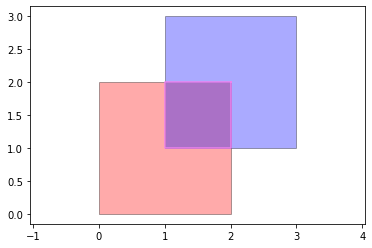

In [290]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.add_patch(descartes.PolygonPatch(db['square1'], fc='red', alpha=1 / 3))
ax.add_patch(descartes.PolygonPatch(db['square2'], fc='blue', alpha=1 / 3))
#ax.plot(*db['union(square1,square2)'].exterior.xy, color='green')
ax.plot(*db['intersect(square1,square2)'].exterior.xy, color='violet')

ax.axis('equal')
plt.show()